# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from math import sqrt
from matplotlib import pyplot

In [2]:
import warnings
warnings.filterwarnings('ignore')

---

# Carga de datos

In [3]:
auctions = pd.read_pickle("../../../../data/tp2/auctions_tp2_formateado.pkl")
clicks = pd.read_pickle("../../../../data/tp2/clicks_tp2_formateado.pkl")
events = pd.read_pickle("../../../../data/tp2/events_tp2_formateado.pkl")
installs = pd.read_pickle("../../../../data/tp2/clicks_tp2_formateado.pkl")

---

# Cargo dispositivos de la competencia

In [4]:
targets = pd.read_pickle("../../../../data/tp2/ref_hashes_target.pkl")

---

# Cargo los labels calculados hasta el momento

In [5]:
labels_v1 = pd.read_pickle("../../targets/targets_ventana_1_auctions.pkl")
labels_v2 = pd.read_pickle("../../targets/targets_ventana_2_auctions.pkl")
labels_v3 = pd.read_pickle("../../targets/targets_ventana_3_auctions.pkl")
labels_v4 = pd.read_pickle("../../targets/targets_ventana_4_auctions.pkl")
labels_v5 = pd.read_pickle("../../targets/targets_ventana_5_auctions.pkl")

# Observo que tan uniforme es el comportamiento de los dispositivos

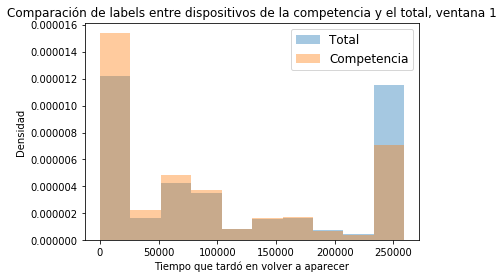

In [39]:
sns.distplot(labels_v1["target"],  kde=False, label='Total',norm_hist=True,bins=10)
sns.distplot(labels_v1.loc[labels_v1.index.isin(targets.index)]["target"],  kde=False, label='Competencia', norm_hist=True, bins=10)

plt.legend(prop={'size': 12})
plt.title('Comparación de labels entre dispositivos de la competencia y el total, ventana 1')
plt.xlabel('Tiempo que tardó en volver a aparecer')
plt.ylabel('Densidad');

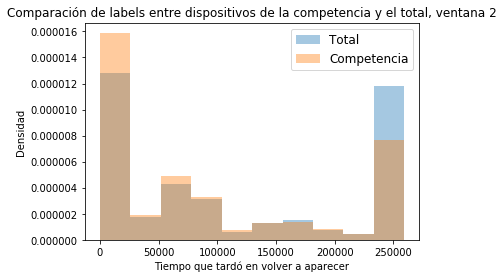

In [40]:
sns.distplot(labels_v2["target"],  kde=False, label='Total',norm_hist=True,bins=10)
sns.distplot(labels_v2.loc[labels_v2.index.isin(targets.index)]["target"],  kde=False, label='Competencia', norm_hist=True, bins=10)

plt.legend(prop={'size': 12})
plt.title('Comparación de labels entre dispositivos de la competencia y el total, ventana 2')
plt.xlabel('Tiempo que tardó en volver a aparecer')
plt.ylabel('Densidad');

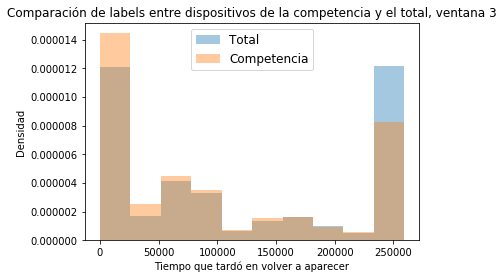

In [41]:
sns.distplot(labels_v3["target"],  kde=False, label='Total',norm_hist=True,bins=10)
sns.distplot(labels_v3.loc[labels_v3.index.isin(targets.index)]["target"],  kde=False, label='Competencia', norm_hist=True, bins=10)

plt.legend(prop={'size': 12})
plt.title('Comparación de labels entre dispositivos de la competencia y el total, ventana 3')
plt.xlabel('Tiempo que tardó en volver a aparecer')
plt.ylabel('Densidad');

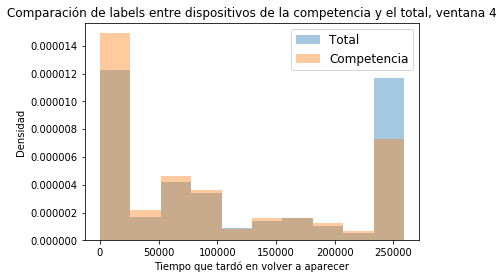

In [42]:
sns.distplot(labels_v4["target"],  kde=False, label='Total',norm_hist=True,bins=10)
sns.distplot(labels_v4.loc[labels_v4.index.isin(targets.index)]["target"],  kde=False, label='Competencia', norm_hist=True, bins=10)

plt.legend(prop={'size': 12})
plt.title('Comparación de labels entre dispositivos de la competencia y el total, ventana 4')
plt.xlabel('Tiempo que tardó en volver a aparecer')
plt.ylabel('Densidad');

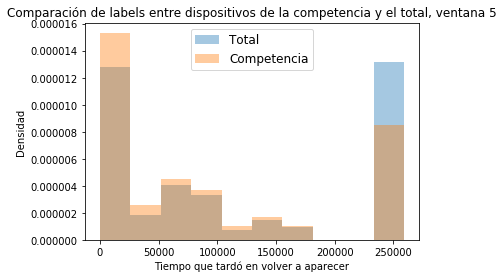

In [43]:
sns.distplot(labels_v5["target"],  kde=False, label='Total',norm_hist=True,bins=10)
sns.distplot(labels_v5.loc[labels_v5.index.isin(targets.index)]["target"],  kde=False, label='Competencia', norm_hist=True, bins=10)

plt.legend(prop={'size': 12})
plt.title('Comparación de labels entre dispositivos de la competencia y el total, ventana 5')
plt.xlabel('Tiempo que tardó en volver a aparecer')
plt.ylabel('Densidad');

---

# Análisis de similaridad de dispositivos
Me interesa ver:
- Todos los dispositivos que aparecen en la ventana 1 de auctions y events
- Todos los dispositivos que aparecen en la ventana 3 de auctions, events y clicks, etc

### Armo ventanas

In [6]:
for ventana_nro in range(1,6):
    auctions["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= auctions["date"].dt.day) & ((auctions["date"].dt.day) <= (19+ventana_nro)))

In [7]:
auctions["ventana_final"] = (((25) <= auctions["date"].dt.day) & ((auctions["date"].dt.day) <= (27)))

In [8]:
for ventana_nro in range(1,6):
    events["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= events["date"].dt.day) & ((events["date"].dt.day) <= (19+ventana_nro)))

In [9]:
events["ventana_final"] = (((25) <= events["date"].dt.day) & ((events["date"].dt.day) <= (27)))

In [10]:
for ventana_nro in range(1,6):
    clicks["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= clicks["created"].dt.day) & ((clicks["created"].dt.day) <= (19+ventana_nro)))

In [11]:
clicks["ventana_final"] = (((25) <= clicks["created"].dt.day) & ((clicks["created"].dt.day) <= (27)))

In [12]:
for ventana_nro in range(1,6):
    installs["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= installs["created"].dt.day) & ((installs["created"].dt.day) <= (19+ventana_nro)))

In [13]:
installs["ventana_final"] = (((25) <= installs["created"].dt.day) & ((installs["created"].dt.day) <= (27)))

---

# Renombro columnas

In [14]:
events.rename(columns={"ref_hash" : "device_id"}, inplace=True)

In [15]:
installs.rename(columns={"ref_hash" : "device_id"}, inplace=True)

In [16]:
clicks.rename(columns={"ref_hash" : "device_id"}, inplace=True)

---

In [96]:
caracteristicas = targets.copy()

In [97]:
caracteristicas["en_v1_auctions"] = caracteristicas.index.isin(auctions.loc[auctions["ventana_1"]]["device_id"])

In [120]:
datasets = [auctions, installs, clicks, events]
datasets_nombres = ["auctions", "installs", "clicks", "events"]
ventanas = ["ventana_1", "ventana_2", "ventana_3", "ventana_4", "ventana_5", "ventana_final"]

In [123]:
for dataset in range(4):
    for ventana in ventanas:
        caracteristicas["en_{}_{}".format(ventana, datasets_nombres[dataset])] = caracteristicas.index.isin(datasets[dataset].loc[datasets[dataset][ventana]]["device_id"])

---

In [19]:
targets_ventana_1 = targets.copy()

In [20]:
targets_ventana_1["en_v1_auctions"] = targets_ventana_1.index.isin(auctions.loc[auctions["ventana_1"]]["device_id"])

In [21]:
targets_ventana_1["en_v1_events"] = targets_ventana_1.index.isin(events.loc[events["ventana_1"]]["device_id"])

In [22]:
targets_ventana_1["en_v1_clicks"] = targets_ventana_1.index.isin(clicks.loc[clicks["ventana_1"]]["device_id"])

In [23]:
targets_ventana_1["en_v1_installs"] = targets_ventana_1.index.isin(installs.loc[clicks["ventana_1"]]["device_id"])

In [28]:
targets_ventana_1["OR"] = (targets_ventana_1["en_v1_auctions"] | targets_ventana_1["en_v1_events"] | targets_ventana_1["en_v1_clicks"] | targets_ventana_1["en_v1_installs"])

In [30]:
targets_ventana_1_alguna = targets_ventana_1.loc[targets_ventana_1["OR"]]

In [35]:
targets_ventana_1_alguna.groupby(['en_v1_auctions', 'en_v1_events', 'en_v1_clicks', 'en_v1_installs']).agg("count")

OR
en_v1_auctions en_v1_events en_v1_clicks en_v1_installs      
False          True         False        False            271
True           False        False        False           1597
                            True         True              39
               True         False        False           1056
                            True         True              53

---

In [46]:
devices_auctions = auctions["device_id"].drop_duplicates()

In [47]:
devices_events = events["device_id"].drop_duplicates()

In [49]:
devices_clicks = clicks["device_id"].drop_duplicates()

In [50]:
devices_installs = installs["device_id"].drop_duplicates()

In [72]:
devices_todos = (devices_auctions.append(devices_events).append(devices_clicks).append(devices_installs)).drop_duplicates()

In [73]:
devices_todos = devices_todos.to_frame()

In [74]:
devices_todos = devices_todos.set_index("device_id")

---

In [76]:
devices_todos["en_v1_auctions"] = devices_todos.index.isin(auctions.loc[auctions["ventana_1"]]["device_id"])

In [77]:
devices_todos["en_v1_events"] = devices_todos.index.isin(events.loc[events["ventana_1"]]["device_id"])

In [78]:
devices_todos["en_v1_clicks"] = devices_todos.index.isin(clicks.loc[clicks["ventana_1"]]["device_id"])

In [79]:
devices_todos["en_v1_installs"] = devices_todos.index.isin(installs.loc[clicks["ventana_1"]]["device_id"])

In [80]:
devices_todos["OR"] = (devices_todos["en_v1_auctions"] | devices_todos["en_v1_events"] | devices_todos["en_v1_clicks"] | devices_todos["en_v1_installs"])

In [81]:
devices_todos_alguna = devices_todos.loc[devices_todos["OR"]]

In [82]:
devices_todos_alguna.groupby(['en_v1_auctions', 'en_v1_events', 'en_v1_clicks', 'en_v1_installs']).agg("count")

OR
en_v1_auctions en_v1_events en_v1_clicks en_v1_installs        
False          False        True         True                64
               True         False        False            88705
                            True         True                39
True           False        False        False           235347
                            True         True              5720
               True         False        False            73896
                            True         True              3362

In [83]:
targets_ventana_1_alguna.groupby(['en_v1_auctions', 'en_v1_events', 'en_v1_clicks', 'en_v1_installs']).agg("count")

OR
en_v1_auctions en_v1_events en_v1_clicks en_v1_installs      
False          True         False        False            271
True           False        False        False           1597
                            True         True              39
               True         False        False           1056
                            True         True              53

---

# Nuevo análisis enfocado en ventana 1

### Me quedo con los dispositivos que estén en la ventana 1 y en la competencia

In [23]:
dispositivos = targets.merge(auctions.loc[auctions["ventana_1"]]["device_id"], left_index=True, how="inner", right_on="device_id")

In [25]:
dispositivos = dispositivos.drop_duplicates()

In [29]:
dispositivos.set_index("device_id", inplace=True)

In [31]:
dispositivos = dispositivos.merge(labels_v1, left_index=True, right_index=True)

---

# Analizo presencia en los demás sets de datos

In [36]:
dispositivos["en_v1_events"] = dispositivos.index.isin(events.loc[events["ventana_1"]]["device_id"].drop_duplicates())

In [38]:
dispositivos["en_v1_clicks"] = dispositivos.index.isin(clicks.loc[clicks["ventana_1"]]["device_id"].drop_duplicates())

In [39]:
dispositivos["en_v1_installs"] = dispositivos.index.isin(installs.loc[installs["ventana_1"]]["device_id"].drop_duplicates())

In [42]:
dispositivos = dispositivos[ [c for c in dispositivos if c not in ["target"]] + ["target"] ]

In [46]:
dispositivos.groupby(['en_v1_events', 'en_v1_clicks', 'en_v1_installs']).agg("count")

target
en_v1_events en_v1_clicks en_v1_installs        
False        False        False             1597
             True         True                39
True         False        False             1056
             True         True                53

---

# Analizo performance para dispositivos que sólo están en auctions

In [75]:
# Cargo features de auctions
features_auctions_v1 = pd.read_pickle("../../features/auctions_train_ventana_1.pkl")

In [76]:
solo_en_ventana_1 = dispositivos.loc[(dispositivos["en_v1_events"] == False) & (dispositivos["en_v1_clicks"] == False) & (dispositivos["en_v1_installs"] == False)]

In [77]:
solo_en_ventana_1 = features_auctions_v1.merge(solo_en_ventana_1.drop(["en_v1_events", "en_v1_clicks", "en_v1_installs"], axis=1), left_index=True, right_index=True)

In [78]:
solo_en_ventana_1.head()

,cantidad_apariciones,apariciones_en_hora_0,apariciones_en_hora_1,apariciones_en_hora_2,apariciones_en_hora_3,apariciones_en_hora_4,apariciones_en_hora_5,apariciones_en_hora_6,apariciones_en_hora_7,apariciones_en_hora_8,...,apariciones_en_source_4,apariciones_en_source_5,apariciones_en_source_6,apariciones_en_source_7,apariciones_en_source_8,apariciones_en_source_9,tiempo_ultima_aparicion_hasta_fin_ventana,tiempo_hora_frec_aparicion_subasta,tiempo_segunda_hora_frec_aparicion,target
4698733293136445042,66,2,0,1,4,0,0,0,0,0,...,0,5,0,0,1,0,24384.076393,57600,0,46098.238130
3036512749306595568,130,23,5,6,13,10,7,0,0,0,...,0,0,0,0,2,0,11.339873,0,0,1853.414668
7459715895483226863,279,17,12,21,20,24,17,7,3,0,...,0,8,2,9,0,0,3169.520181,72000,0,3782.541079
173037676676551667,30,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,88078.912427,61200,0,10000.553578
1978663103663783493,20,1,0,0,6,0,2,0,0,4,...,0,0,0,0,1,0,75514.974274,10800,0,62346.251348


In [80]:
X, y = solo_en_ventana_1.iloc[:,:-1], solo_en_ventana_1.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':7,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.01}


num_round = 5000
stopping = 15
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)

[0]	train-rmse:132506	test-rmse:132027
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 15 rounds.
[1]	train-rmse:131586	test-rmse:131249
[2]	train-rmse:130723	test-rmse:130482
[3]	train-rmse:129838	test-rmse:129774
[4]	train-rmse:128981	test-rmse:129079
[5]	train-rmse:128136	test-rmse:128380
[6]	train-rmse:127269	test-rmse:127630
[7]	train-rmse:126432	test-rmse:126950
[8]	train-rmse:125598	test-rmse:126263
[9]	train-rmse:124776	test-rmse:125585
[10]	train-rmse:123965	test-rmse:124964
[11]	train-rmse:123153	test-rmse:124266
[12]	train-rmse:122344	test-rmse:123614
[13]	train-rmse:121547	test-rmse:122982
[14]	train-rmse:120766	test-rmse:122330
[15]	train-rmse:119964	test-rmse:121705
[16]	train-rmse:119172	test-rmse:121085
[17]	train-rmse:118426	test-rmse:120488
[18]	train-rmse:117669	test-rmse:119885
[19]	train-rmse:116934	test-rmse:119295
[20]	train-rmse:116167	test-rmse:118720
[21]	train-rmse:115441	test

RMSE: 87881.26150771862


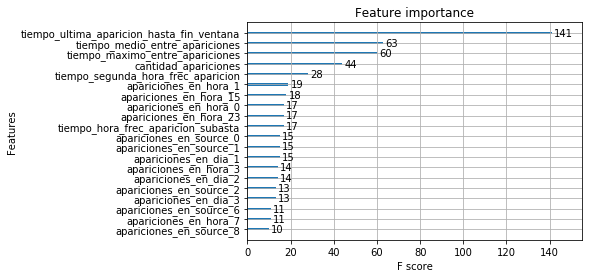

In [81]:
X, y = solo_en_ventana_1.iloc[:,:-1], solo_en_ventana_1.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=123)

# fit model on all training data
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: {}".format(sqrt(rmse)))

xgb.plot_importance(model, max_num_features=20)
pyplot.show()

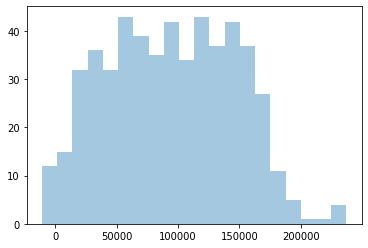

In [103]:
sns.distplot(y_pred,  kde=False, label='Total',bins=20);

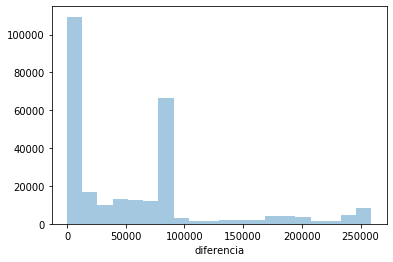

In [99]:
v1_vs_v2 = labels_v1.merge(labels_v2, left_index=True, right_index=True, suffixes=("_1","_2"))

v1_vs_v2["diferencia"] = v1_vs_v2["target_1"] - v1_vs_v2["target_2"]

sns.distplot(abs(v1_vs_v2["diferencia"]),  kde=False, label='Total',bins=20);

---

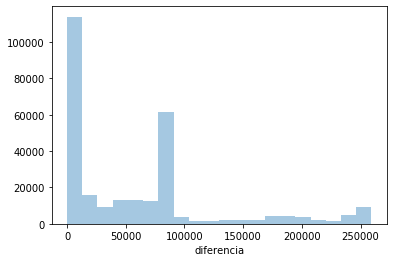

In [101]:
v2_vs_v3 = labels_v2.merge(labels_v3, left_index=True, right_index=True, suffixes=("_2","_3"))

v2_vs_v3["diferencia"] = v2_vs_v3["target_2"] - v2_vs_v3["target_3"]

sns.distplot(abs(v2_vs_v3["diferencia"]),  kde=False, label='Total',bins=20);

---

In [104]:
# Cargo features de auctions
features_auctions_v2 = pd.read_pickle("../../features/auctions_train_ventana_2.pkl")

In [161]:
# Cargo features de auctions
features_auctions_v3 = pd.read_pickle("../../features/auctions_train_ventana_3.pkl")

In [177]:
# Cargo features de auctions
features_auctions_v4 = pd.read_pickle("../../features/auctions_train_ventana_4.pkl")

In [180]:
en_v1_y_v2_y_v3_y_v4 = features_auctions_v4.loc[(features_auctions_v4.index.isin((features_auctions_v3.index))) & (features_auctions_v4.index.isin((features_auctions_v1.index)) & (features_auctions_v4.index.isin(features_auctions_v2.index)))]

In [182]:
en_v1_y_v2_y_v3_y_v4 = en_v1_y_v2_y_v3_y_v4.merge(labels_v1, left_index=True, right_index=True)

In [183]:
en_v1_y_v2_y_v3_y_v4 = en_v1_y_v2_y_v3_y_v4.merge(labels_v2, left_index=True, right_index=True, suffixes=("_1", "_2"))

In [184]:
en_v1_y_v2_y_v3_y_v4 = en_v1_y_v2_y_v3_y_v4.merge(labels_v3, left_index=True, right_index=True)

In [185]:
en_v1_y_v2_y_v3_y_v4 = en_v1_y_v2_y_v3_y_v4.merge(labels_v4, left_index=True, right_index=True, suffixes=("_3", "_4"))

In [199]:
en_v1_y_v2_y_v3_y_v4["tiene_target_menor_a25000"] = ( (en_v1_y_v2_y_v3_y_v4["target_1"] <= 25000) | (en_v1_y_v2_y_v3_y_v4["target_2"] <= 25000) | (en_v1_y_v2_y_v3_y_v4["target_3"] <= 25000))

In [200]:
en_v1_y_v2_y_v3_y_v4["tiene_target_menor_a25000"] = en_v1_y_v2_y_v3_y_v4["tiene_target_menor_a25000"].astype(np.int8)

In [204]:
en_v1_y_v2_y_v3_y_v4["suma_targets"] = ( en_v1_y_v2_y_v3_y_v4["target_1"]  + en_v1_y_v2_y_v3_y_v4["target_2"]  + en_v1_y_v2_y_v3_y_v4["target_3"])

In [205]:
en_v1_y_v2_y_v3_y_v4["promedio_targets"] = (en_v1_y_v2_y_v3_y_v4["suma_targets"] / 3)

In [207]:
en_v1_y_v2_y_v3_y_v4["tiene_target_grande"] = ( (en_v1_y_v2_y_v3_y_v4["target_1"] >= 200000) | (en_v1_y_v2_y_v3_y_v4["target_2"] >= 200000) | (en_v1_y_v2_y_v3_y_v4["target_3"] >= 200000))

In [208]:
en_v1_y_v2_y_v3_y_v4["tiene_target_grande"] = en_v1_y_v2_y_v3_y_v4["tiene_target_grande"].astype(np.int8)

RMSE: 60506.75247527026


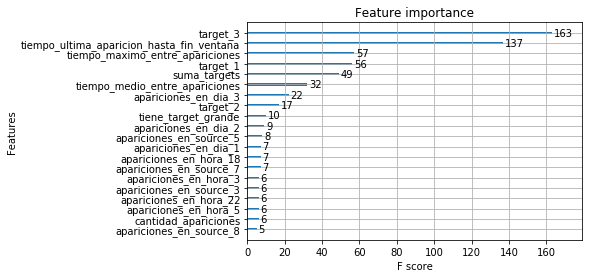

[0]	train-rmse:138505	test-rmse:138201
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 15 rounds.
[1]	train-rmse:137408	test-rmse:137106
[2]	train-rmse:136314	test-rmse:136016
[3]	train-rmse:135236	test-rmse:134942
[4]	train-rmse:134163	test-rmse:133872
[5]	train-rmse:133119	test-rmse:132830
[6]	train-rmse:132075	test-rmse:131789
[7]	train-rmse:131073	test-rmse:130790
[8]	train-rmse:130053	test-rmse:129773
[9]	train-rmse:129045	test-rmse:128769
[10]	train-rmse:128047	test-rmse:127774
[11]	train-rmse:127065	test-rmse:126794
[12]	train-rmse:126094	test-rmse:125827
[13]	train-rmse:125136	test-rmse:124872
[14]	train-rmse:124210	test-rmse:123948
[15]	train-rmse:123277	test-rmse:123018
[16]	train-rmse:122358	test-rmse:122103
[17]	train-rmse:121449	test-rmse:121197
[18]	train-rmse:120548	test-rmse:120298
[19]	train-rmse:119670	test-rmse:119424
[20]	train-rmse:118791	test-rmse:118548
[21]	train-rmse:117932	test

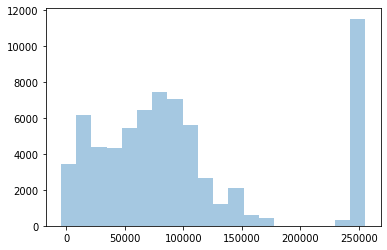

In [210]:
X, y = en_v1_y_v2_y_v3_y_v4.drop("target_4", axis=1), en_v1_y_v2_y_v3_y_v4["target_4"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=123)

# fit model on all training data
model = xgb.XGBRegressor(n_jobs=6)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: {}".format(sqrt(rmse)))

xgb.plot_importance(model, max_num_features=20)
pyplot.show()
sns.distplot(y_pred,  kde=False, label='Total',bins=20);


dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':7,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.01}


num_round = 5000
stopping = 15
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)

---

# Prueba Bimodal
Prueba sólamente para la ventana 1

In [177]:
features_v1 = pd.read_pickle("../../features/auctions_train_ventana_1.pkl")
labels = pd.read_pickle("../../targets/targets_ventana_1_auctions.pkl")
train = features_v1.merge(labels, left_index=True, right_index=True)

In [178]:
def categoria(x):
    if x < 5000:
        return 0
    else:
        return 1

In [179]:
train["label_categoria"] = train["target"].apply(lambda x: categoria(x))

Accuracy: 90.13%


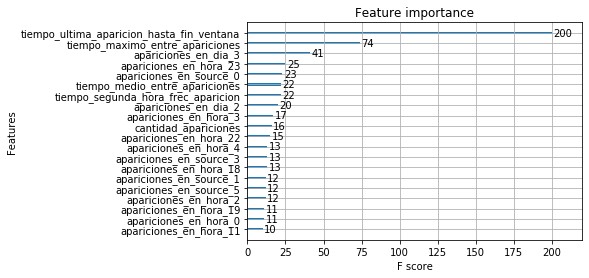

In [180]:
X, y = train.drop(["label_categoria", "target"], axis=1), train["label_categoria"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.4, random_state=123)

# fit model on all training data
model = xgb.XGBClassifier(n_jobs=6)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
xgb.plot_importance(model, max_num_features=20)
pyplot.show()

In [181]:
X_test["categoria_predicha"] = model.predict(X_test)

In [182]:
nuevo_train = X_test

In [183]:
nuevo_train = nuevo_train.merge(labels, left_index=True, right_index=True)

### Modelo 1

RMSE: 32005.676335083048


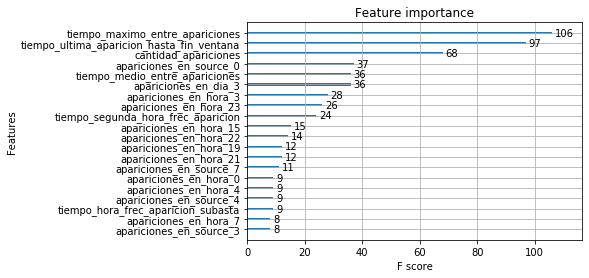

In [184]:
train_modelo_1 = nuevo_train.loc[nuevo_train["categoria_predicha"] == 0]
train_modelo_1 = train_modelo_1.drop("categoria_predicha", axis=1)
X1, y1 = train_modelo_1.drop(["target"], axis=1), train_modelo_1["target"]
X_train1, X_test1, y_train1, y_test1 = \
    train_test_split(X1, y1, test_size=0.4, random_state=123)

# fit model on all training data
model1 = xgb.XGBRegressor(n_jobs=6)
model1.fit(X_train1, y_train1)
# make predictions for test data and evaluate
y_pred1 = model1.predict(X_test1)

# evaluate predictions
rmse = mean_squared_error(y_test1, y_pred1)
print("RMSE: {}".format(sqrt(rmse)))
xgb.plot_importance(model1, max_num_features=20)
pyplot.show()

RMSE: 87762.96652716579


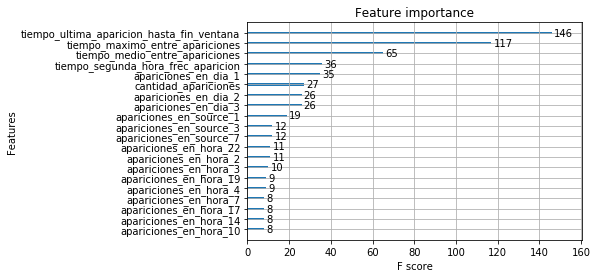

In [175]:
train_modelo_2 = nuevo_train.loc[nuevo_train["categoria_predicha"] == 1]
train_modelo_2 = train_modelo_2.drop("categoria_predicha", axis=1)
X2, y2 = train_modelo_2.drop(["target"], axis=1), train_modelo_2["target"]
X_train2, X_test2, y_train2, y_test2 = \
    train_test_split(X2, y2, test_size=0.4, random_state=123)

# fit model on all training data
model2 = xgb.XGBRegressor(n_jobs=6)
model2.fit(X_train2, y_train2)
# make predictions for test data and evaluate
y_pred2 = model2.predict(X_test2)

# evaluate predictions
rmse = mean_squared_error(y_test2, y_pred2)
print("RMSE: {}".format(sqrt(rmse)))
xgb.plot_importance(model2, max_num_features=20)
pyplot.show()

---

In [4]:
auctions = pd.read_pickle("../../../../data/tp2/auctions_tp2_formateado.pkl")

In [7]:
targets_en_auctions = auctions.loc[auctions["device_id"].isin(targets.index)]

In [16]:
targets_en_auctions.groupby("device_id").agg({"date" : "count"}).describe(percentiles = [(1 - 1/x) for x in range(1,20)])

,date
count,4037.000000
mean,137.881595
std,435.652577
min,1.000000
0%,1.000000
50%,26.000000
66.7%,58.000000
75%,97.000000
80%,138.000000
83.3%,171.000000
